In [1]:
import numpy as np
from scipy import signal
from scipy.stats import poisson
import matplotlib.pyplot as plt
import warnings

In [2]:
def poisson_process(time_length, rate):
    '''
    Returns an array of times, where each time represents an arrival
    '''
    t = 0
    arrivals = []

    while t < time_length:
        # Generate a random inter-arrival time from an exponential distribution with rate lambda
        inter_arrival_time = np.random.exponential(1 / rate)
        # Update the current time by adding the inter-arrival time
        t += inter_arrival_time
        # If the current time is within the interval [0, T], record the arrival time
        if t < time_length:
            arrivals.append(t)
    return arrivals

In [3]:
def presynaptic_spike_train(e_rate_distr, i_rate_distr, time_length, dt):
    '''
    Args:
        e_rate_distr -- a list containing a set of rates to use for the poission process
                        simulating the spike train for excitatory signals
        i_rate_distr -- a list containing a set of rates to use for the poission process
                        simulating the spike train for inhibitory signals
        time_length -- length in seconds of the signal
        dt -- step size to perform binning and generating the spiketrain from the poission process
    Returns:
        A spike train matrix with the first num_e_sig rows corresponding to excitatory
        spike trains and the last num_i_sig rows corresponding to inhibitory spike trains
        along with the number of excitatory and inhibitory signals.  
    Remarks:
        Most distributions in numpy have an option to specify size, which is what should be 
        used to provide the e_rate_distr and i_rate_distr arrays. 
    '''
    spike_train_input = np.zeros((e_rate_distr.shape[0] + i_rate_distr.shape[0], int(time_length / dt)))
    collisions = 0
    
    for i in range(e_rate_distr.shape[0]):
        for time in poisson_process(time_length, e_rate_distr[i]):
            spike_train_input[i][int(time / dt)] += 1
            if spike_train_input[i][int(time / dt)] > 1:
                collisions += 1
    
    for i in range(i_rate_distr.shape[0]):
        for time in poisson_process(time_length, i_rate_distr[i]):
            spike_train_input[i + e_rate_distr.shape[0]][int(time / dt)] += 1
            if spike_train_input[i + e_rate_distr.shape[0]][int(time / dt)] > 1:
                collisions += 1
                
    if collisions > 0:
        warnings.warn("dt is too large, there are " + str(collisions) + \
                      " instances of arrivals happening at the same time")
        
    return spike_train_input, e_rate_distr.shape[0], i_rate_distr.shape[0]

In [4]:
presynaptic_spike_train(np.random.normal(1, 1e-1, size=2), np.random.normal(1, 1e-1, size=2), 1, 1e-1)

(array([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 2,
 2)

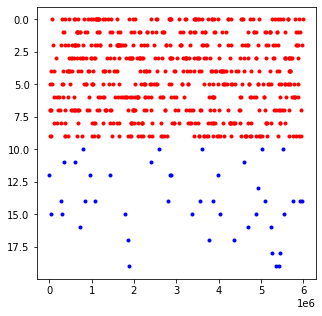

In [5]:
def heatmap(spike_matrix_info):
    '''
    Red is excitatory, and blue is inhibitory
    '''
    spike_matrix, num_e_sig, num_i_sig = spike_matrix_info
    height, width = spike_matrix.shape
    aspect = width / height

    # plot the matrix as a heatmap with adjusted aspect ratio
    fig, ax = plt.subplots(figsize=(5, 5))
    #ax.imshow(matrix, cmap='binary', interpolation='nearest',aspect=aspect)
    for i in range(spike_matrix.shape[0]):
        if i >= num_e_sig:
            col = 'blue'
        else:
            col = 'red'
        for j in range(spike_matrix.shape[1]):
            if spike_matrix[i, j] >= 1:
                ax.scatter(j, i, marker='.', color=col)
    plt.gca().invert_yaxis()
    plt.show()
    
heatmap(presynaptic_spike_train(np.random.normal(10, 1e-1, 10), np.random.normal(1, 1e-1, 10), 6, 1e-6))

In [6]:
def spike_density_function(spike_matrix, dt, std):
    '''
    Generates a spike density function by convolving with 
    a gaussian distribution provided the dt of spike_matrix
    and a given standard deviation. 
    
    std is expected to be in the same units as dt. 
    
    If dt = 1e-3, and std must be given in s.
    '''
    window = signal.windows.exponential(0.1/dt, 0, std/dt, False) # signal.windows.gaussian(0.1 / dt, std=std / dt)
    smooth_spikes = np.zeros((len(spike_matrix), len(spike_matrix[0])))
    
    index = 1
    for spike_train in spike_matrix:
        smooth_signal = signal.convolve(spike_train, window / dt, mode='same') / sum(window)
        fig, (spikes, smooth) = plt.subplots(2, 1)
        spikes.plot(spike_train)
        spikes.set_title('Spike train ' + str(index))
        spikes.set_xlabel('Time (ms)')

        smooth.plot(smooth_signal)
        smooth.set_title('Spike density ' + str(index))
        smooth.set_xlabel('Time (ms)')
        smooth.set_ylabel('Spike rate (Hz)')

        fig.tight_layout()
        fig.show()
        
        smooth_spikes[index - 1] = smooth_signal
        index += 1
    return smooth_spikes

/tmp/ipykernel_282623/2384837939.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [10.42167654,  9.91340537,  9.42992289, ...,  0.66623549,
         0.6337428 ,  0.6028348 ],
       [ 0.        ,  0.        ,  0.        , ...,  2.44461567,
         2.32539035,  2.21197973]])

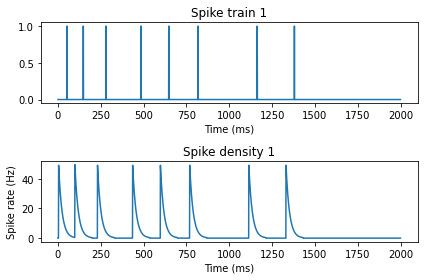

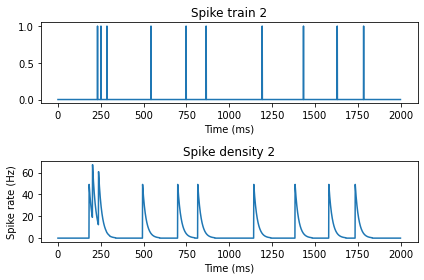

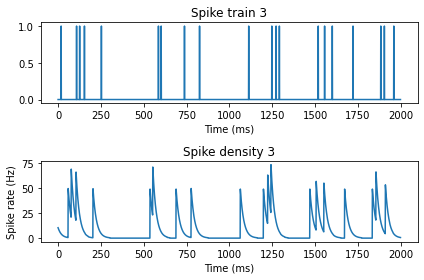

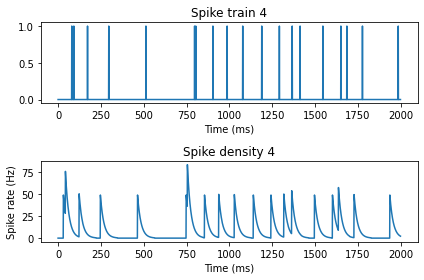

In [7]:
spike_density_function(presynaptic_spike_train(np.random.normal(5, 1e-1, size=2), \
                                               np.random.normal(10, 1e-1, size=2), 2, 1e-3)[0], 1e-3, 2e-2)

In [8]:
import time
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["orange", "green", "purple", "blue", "red"])

def generate_input_spike_trains_for_simulation(sim_duration_ms=6000, num_exc=80, num_inh=20, 
                                               num_exc_spikes_per_100ms_range=[0,100], num_exc_inh_spike_diff_per_100ms_range=[-100,100]):
    # randomly sample inst rate (with some uniform noise) smoothing sigma
    keep_inst_rate_const_for_ms = np.random.choice(inst_rate_sampling_time_interval_options_ms)
    keep_inst_rate_const_for_ms += int(2 * inst_rate_sampling_time_interval_jitter_range * np.random.rand() - inst_rate_sampling_time_interval_jitter_range)
        
    # randomly sample smoothing sigma (with some uniform noise)
    temporal_inst_rate_smoothing_sigma = np.random.choice(temporal_inst_rate_smoothing_sigma_options_ms)
    temporal_inst_rate_smoothing_sigma += int(2 * temporal_inst_rate_smoothing_sigma_jitter_range * np.random.rand() - temporal_inst_rate_smoothing_sigma_jitter_range)
       
    num_inst_rate_samples = int(np.ceil(float(sim_duration_ms) / keep_inst_rate_const_for_ms))
    
    # create the coarse inst rates with units of "total spikes per tree per 100 ms"
    num_ex_spikes_per_100ms   = np.random.uniform(low=num_exc_spikes_per_100ms_range[0], high=num_exc_spikes_per_100ms_range[1], size=(1, num_inst_rate_samples))
    num_inh_spikes_low_range  = np.maximum(0, num_ex_spikes_per_100ms + num_exc_inh_spike_diff_per_100ms_range[0])
    num_inh_spikes_high_range = num_ex_spikes_per_100ms + num_exc_inh_spike_diff_per_100ms_range[1]
    num_inh_spikes_per_100ms  = np.random.uniform(low=num_inh_spikes_low_range, high=num_inh_spikes_high_range, size=(1, num_inst_rate_samples))
    num_inh_spikes_per_100ms[num_inh_spikes_per_100ms < 0] = 0.0001

    # convert to units of "per_1um_per_1ms"
    ex_bas_spike_rate_per_1um_per_1ms   = num_ex_spikes_per_100ms   / (num_exc  * 100.0)
    inh_bas_spike_rate_per_1um_per_1ms  = num_inh_spikes_per_100ms  / (num_inh  * 100.0)
    
    # kron by space (uniform distribution across branches per tree)
    ex_spike_rate_per_seg_per_1ms   = np.kron(ex_bas_spike_rate_per_1um_per_1ms  , np.ones((num_exc,1)))
    inh_spike_rate_per_seg_per_1ms  = np.kron(inh_bas_spike_rate_per_1um_per_1ms , np.ones((num_inh,1)))

    # add some spatial multiplicative randomness (that will be added to the sampling noise)
    ex_spike_rate_per_seg_per_1ms  = np.random.uniform(low=0.5, high=1.5, size=ex_spike_rate_per_seg_per_1ms.shape ) * ex_spike_rate_per_seg_per_1ms
    inh_spike_rate_per_seg_per_1ms = np.random.uniform(low=0.5, high=1.5, size=inh_spike_rate_per_seg_per_1ms.shape) * inh_spike_rate_per_seg_per_1ms

    # kron by time (crop if there are leftovers in the end) to fill up the time to 1ms time bins
    ex_spike_rate_per_seg_per_1ms  = np.kron(ex_spike_rate_per_seg_per_1ms, np.ones((1, keep_inst_rate_const_for_ms)))[:,:sim_duration_ms]
    inh_spike_rate_per_seg_per_1ms = np.kron(inh_spike_rate_per_seg_per_1ms, np.ones((1, keep_inst_rate_const_for_ms)))[:,:sim_duration_ms]
        
    # filter the inst rates according to smoothing sigma
    smoothing_window = signal.gaussian(1.0 + 7 * temporal_inst_rate_smoothing_sigma, std=temporal_inst_rate_smoothing_sigma)[np.newaxis,:]
    smoothing_window /= smoothing_window.sum()
    seg_inst_rate_ex_smoothed  = signal.convolve(ex_spike_rate_per_seg_per_1ms,  smoothing_window, mode='same')
    seg_inst_rate_inh_smoothed = signal.convolve(inh_spike_rate_per_seg_per_1ms, smoothing_window, mode='same')
        
    # sample the instantanous spike prob and then sample the actual spikes
    ex_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_ex_smoothed)
    ex_spikes_bin      = np.random.rand(ex_inst_spike_prob.shape[0], ex_inst_spike_prob.shape[1]) < ex_inst_spike_prob

    inh_inst_spike_prob = np.random.exponential(scale=seg_inst_rate_inh_smoothed)
    inh_spikes_bin      = np.random.rand(inh_inst_spike_prob.shape[0], inh_inst_spike_prob.shape[1]) < inh_inst_spike_prob

    
    for i in range(num_exc):
        fig, (spike_smooth, spiketrain) = plt.subplots(2, 1)
        spike_smooth.plot(ex_spike_rate_per_seg_per_1ms[i])
        spike_smooth.plot(seg_inst_rate_ex_smoothed[i])
        spike_smooth.set_title("Pre-convolved and convolved excitatory spikes")
        spike_smooth.set_xlabel("Time (ms)")

        spiketrain.plot(ex_spikes_bin[i])
        spiketrain.set_title("Excitatory spiketrain generated from distribution")
        spiketrain.set_xlabel("Time (ms)")

        fig.tight_layout()
        fig.show()
        
    for i in range(num_inh):
        fig, (spike_smooth, spiketrain) = plt.subplots(2, 1)
        spike_smooth.plot(inh_spike_rate_per_seg_per_1ms[i])
        spike_smooth.plot(seg_inst_rate_inh_smoothed[i])
        spike_smooth.set_title("Pre-convolved and convolved inhibitory spikes")
        spike_smooth.set_xlabel("Time (ms)")

        spiketrain.plot(inh_spikes_bin[i])
        spiketrain.set_title("Inhibitory spiketrain generated from distribution")
        spiketrain.set_xlabel("Time (ms)")

        fig.tight_layout()
        fig.show()
    
    all_spikes_bin = np.vstack((ex_spikes_bin, inh_spikes_bin))
    
    return all_spikes_bin

/tmp/ipykernel_282623/776712665.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_282623/776712665.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (spike_smooth, spiketrain) = plt.subplots(2, 1)
/tmp/ipykernel_282623/776712665.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

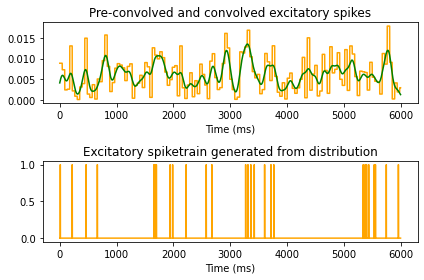

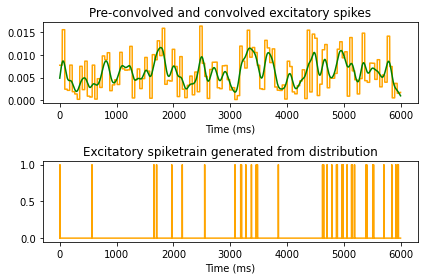

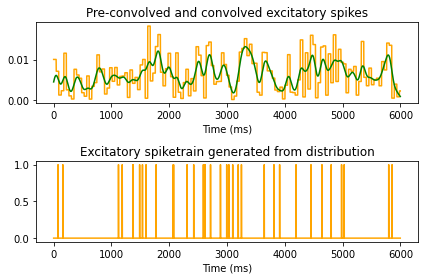

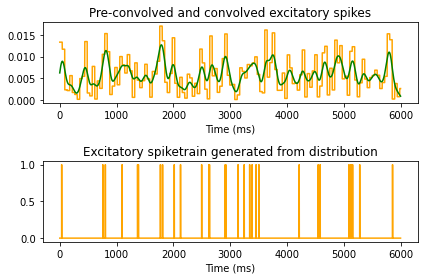

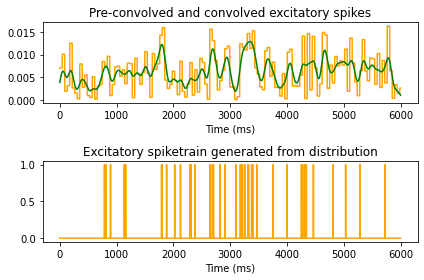

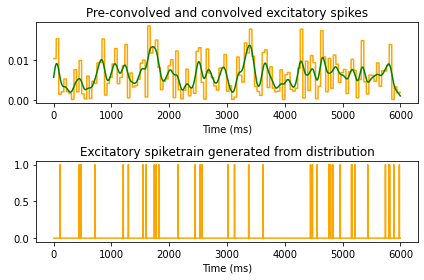

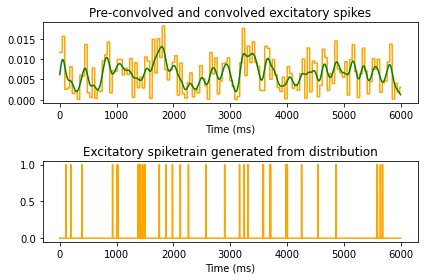

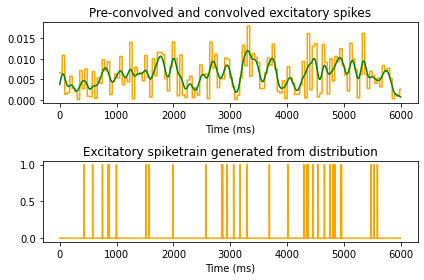

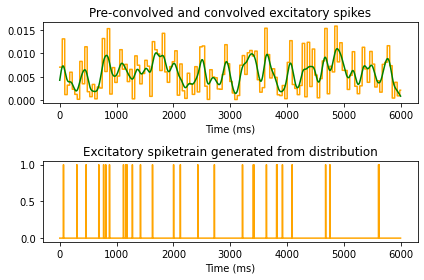

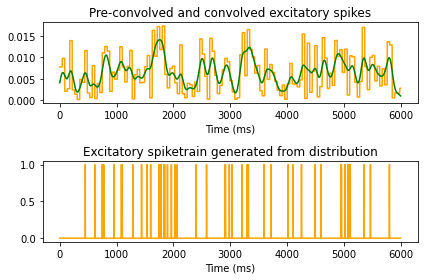

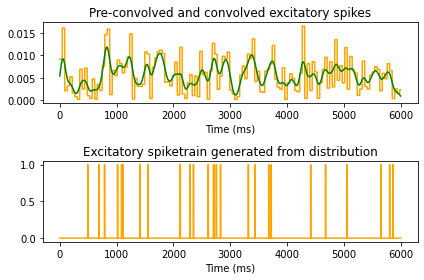

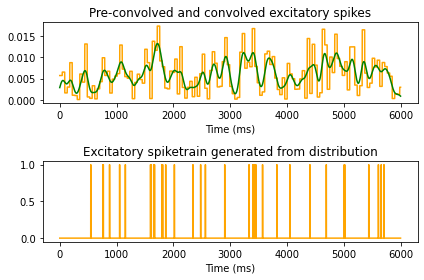

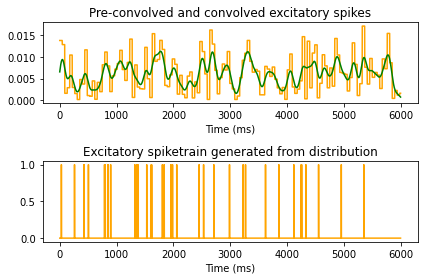

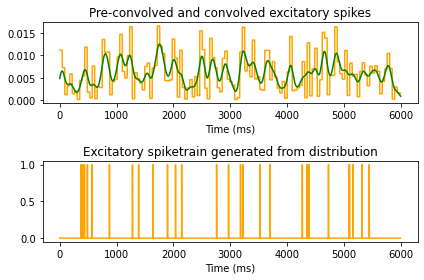

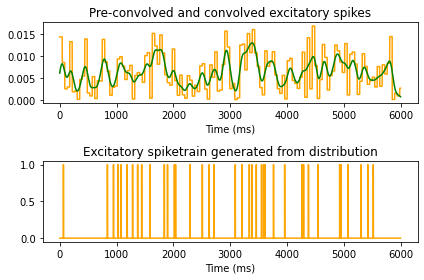

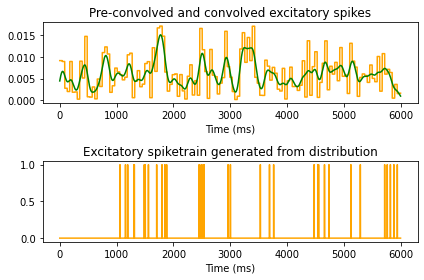

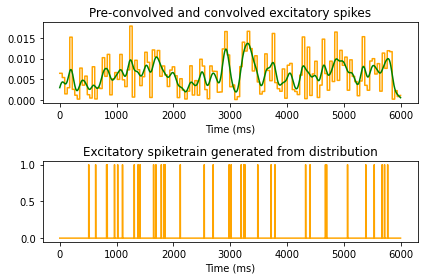

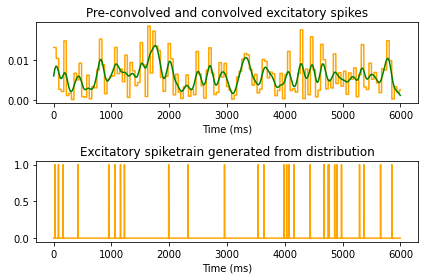

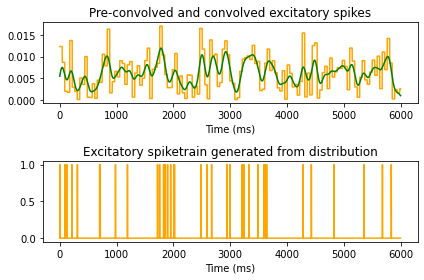

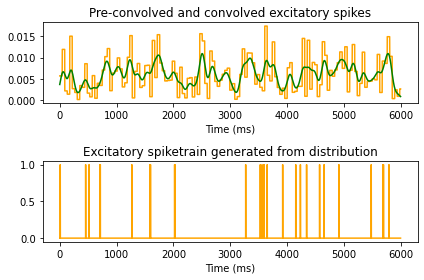

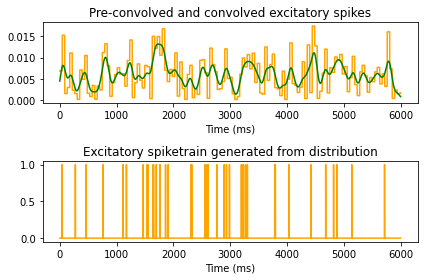

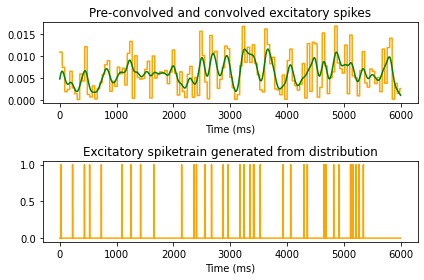

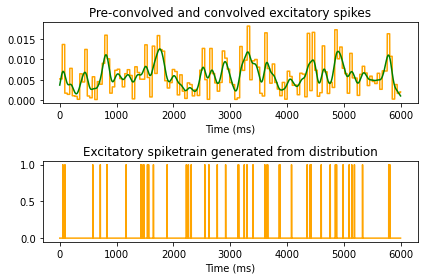

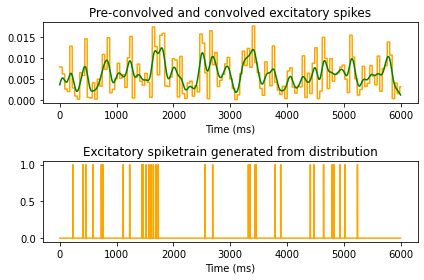

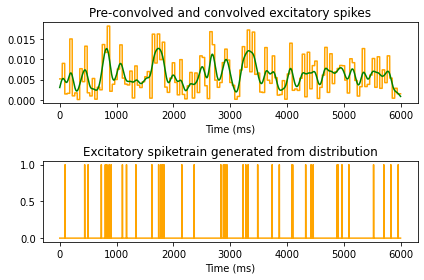

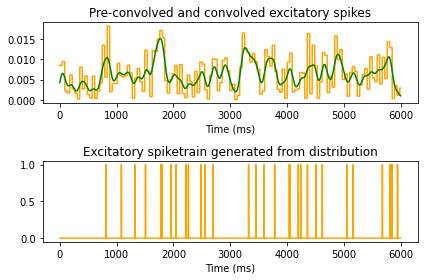

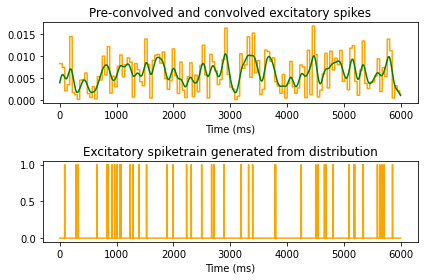

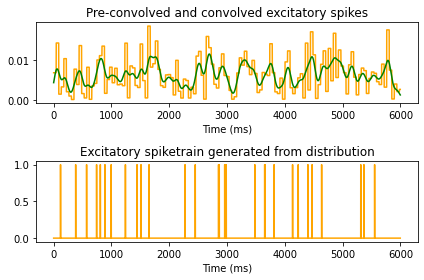

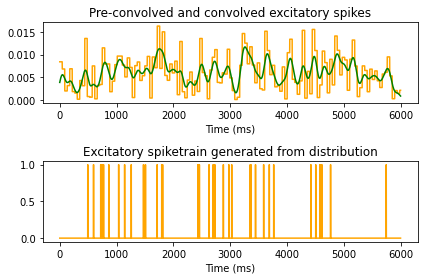

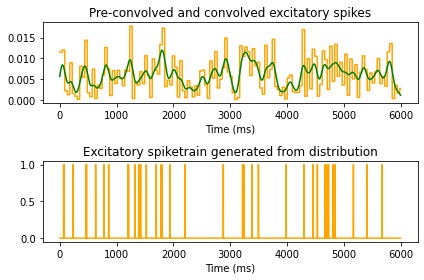

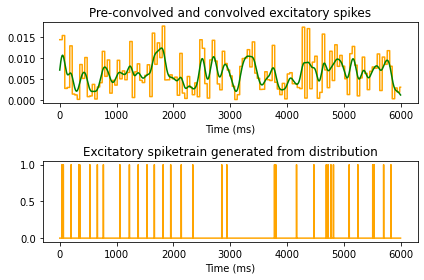

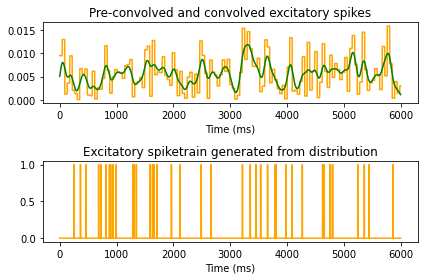

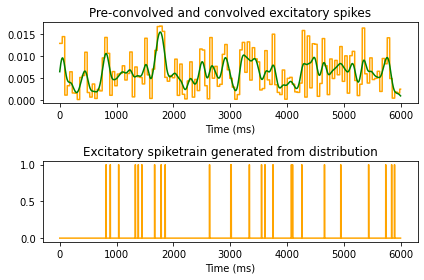

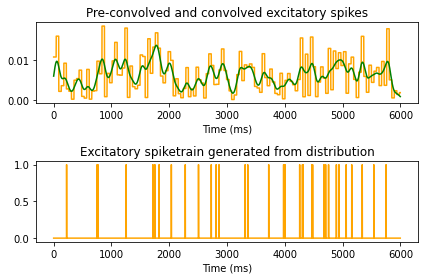

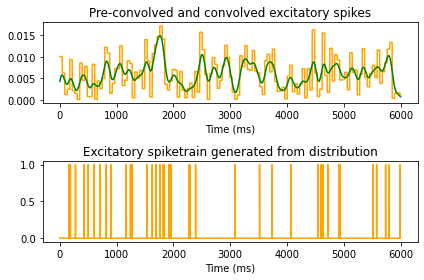

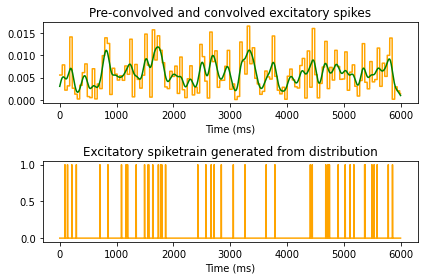

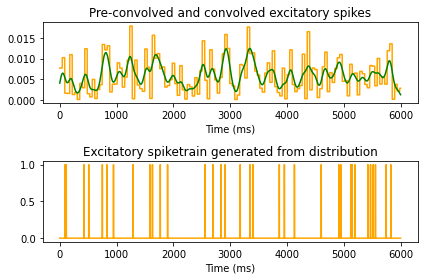

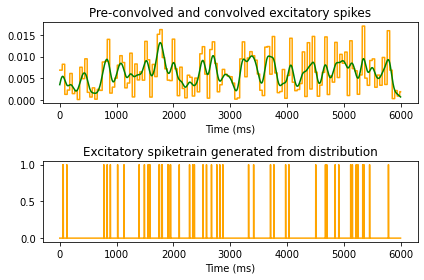

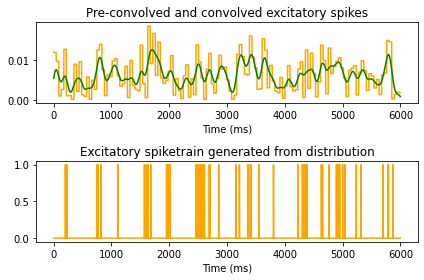

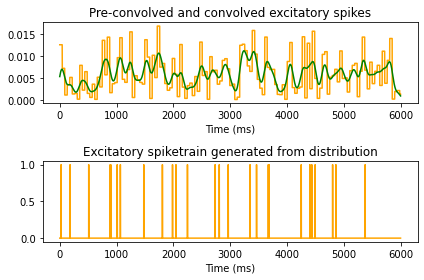

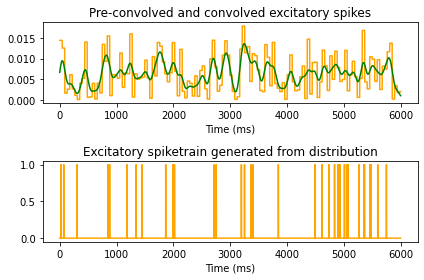

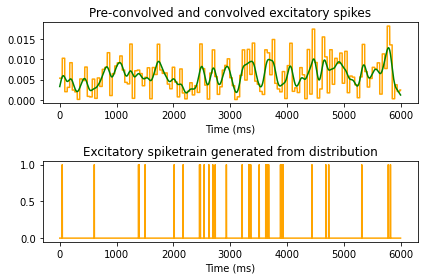

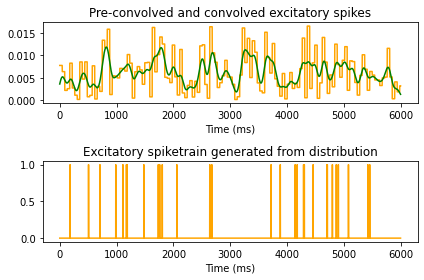

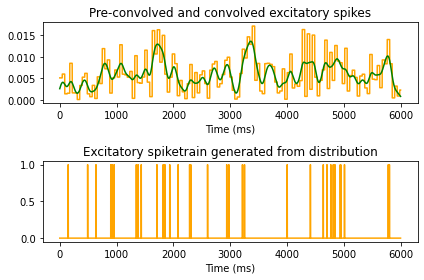

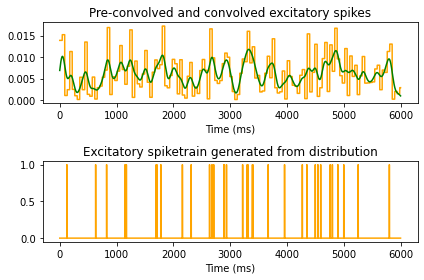

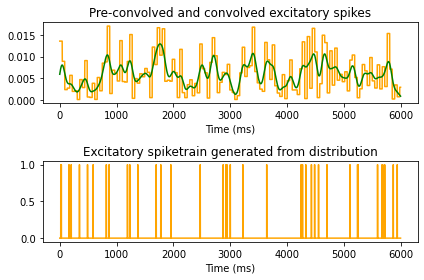

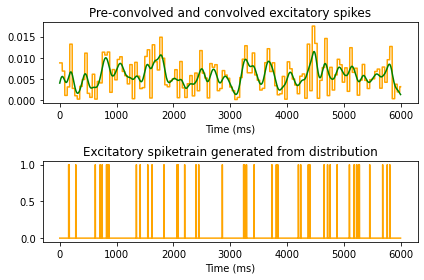

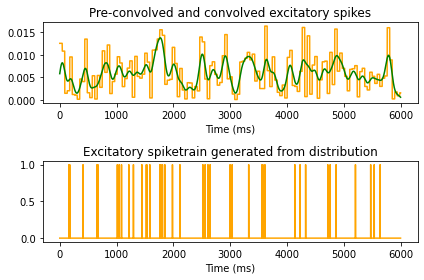

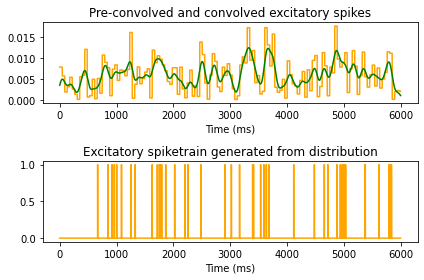

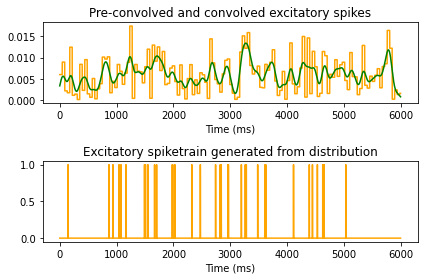

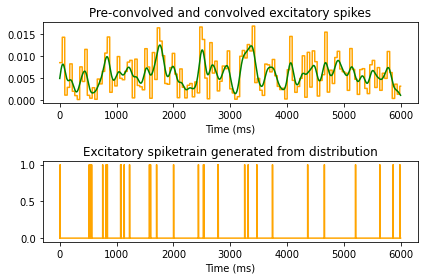

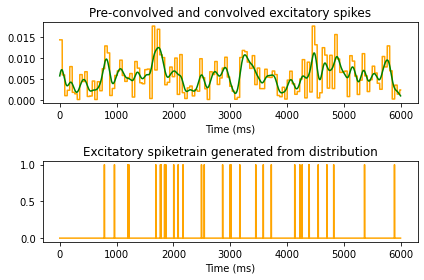

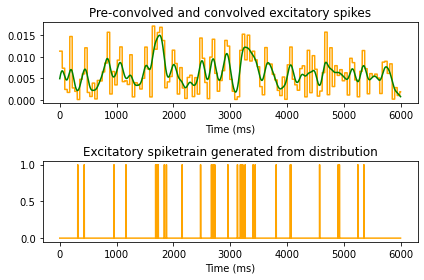

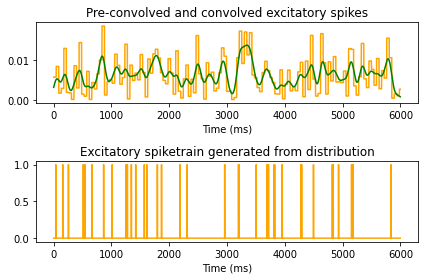

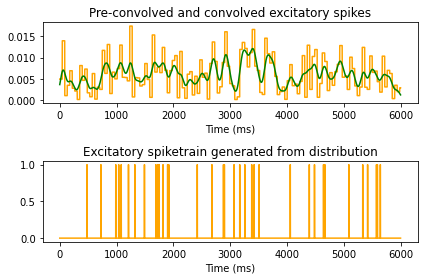

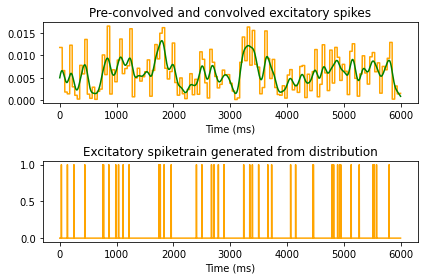

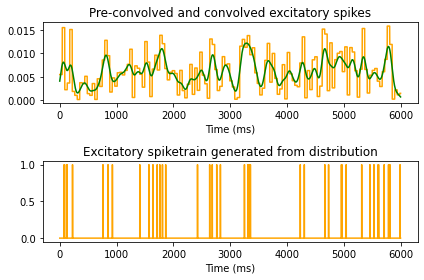

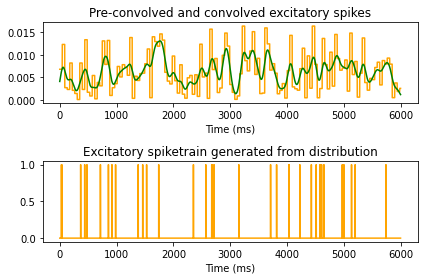

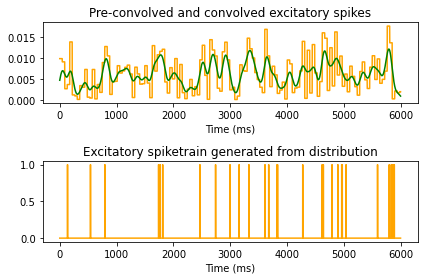

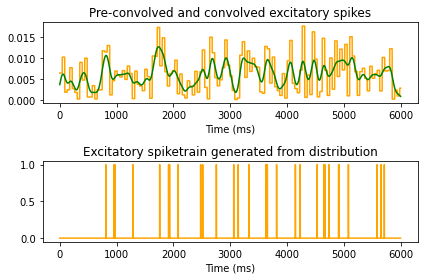

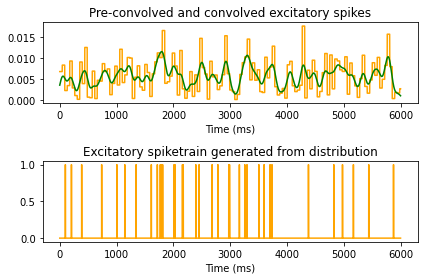

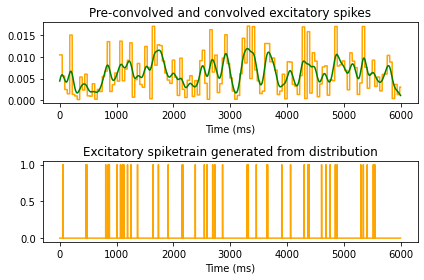

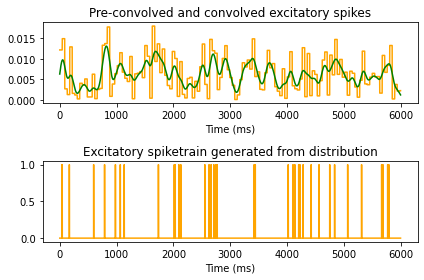

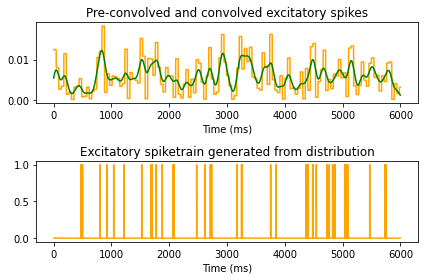

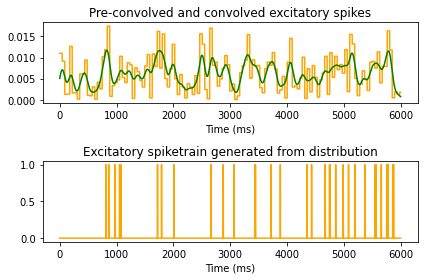

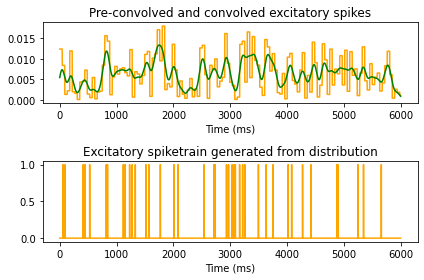

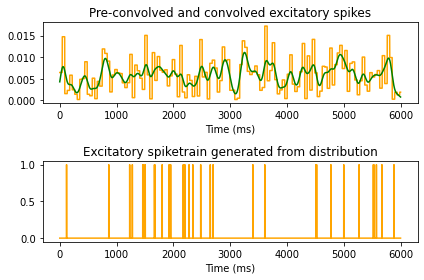

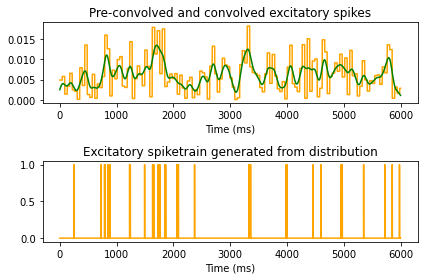

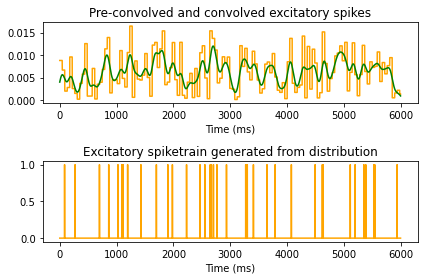

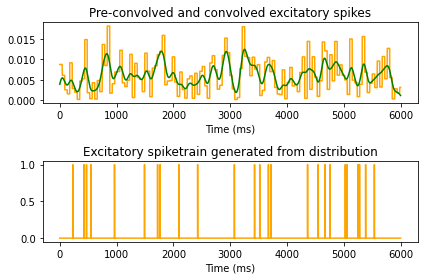

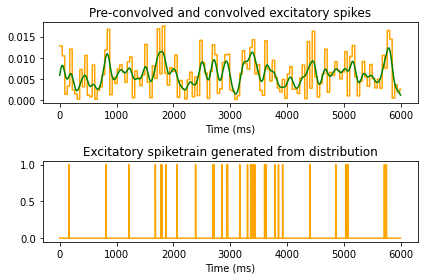

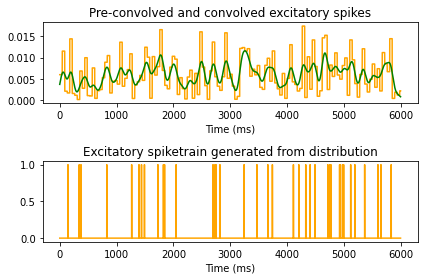

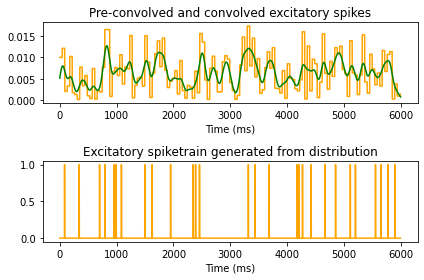

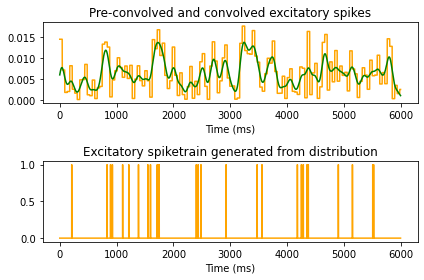

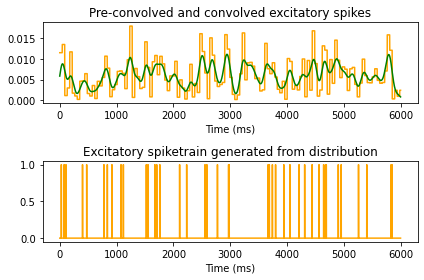

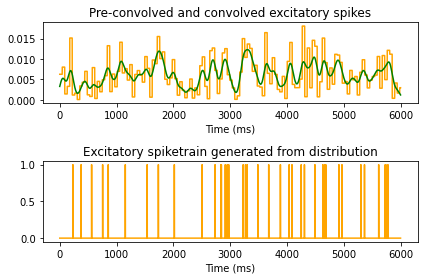

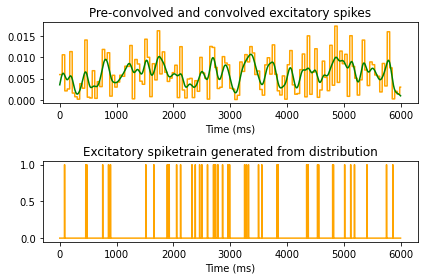

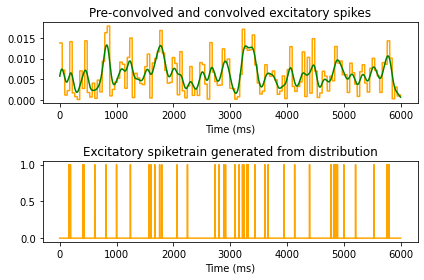

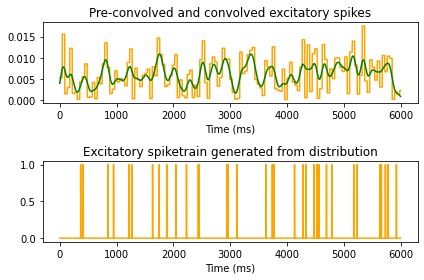

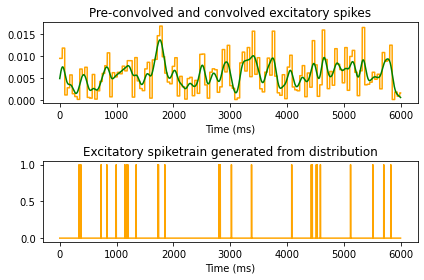

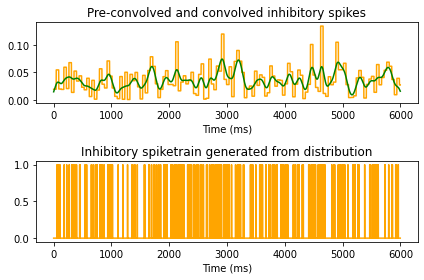

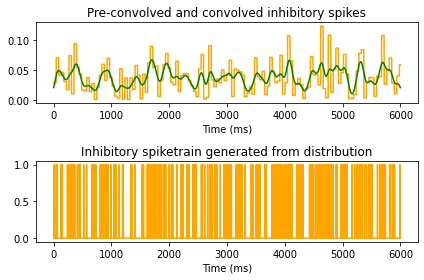

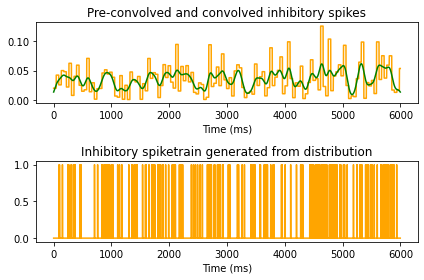

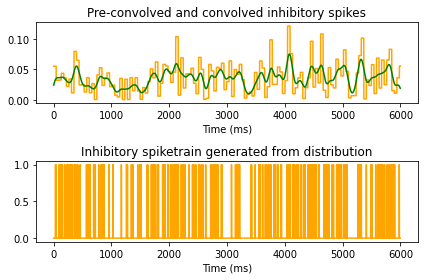

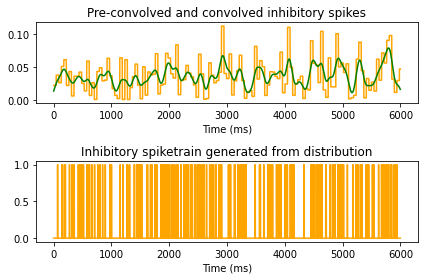

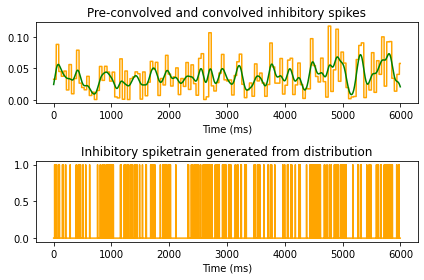

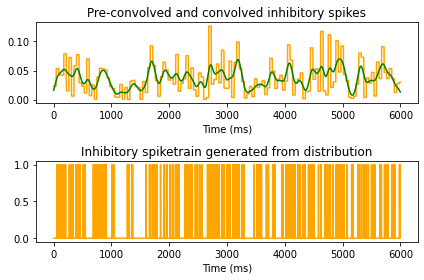

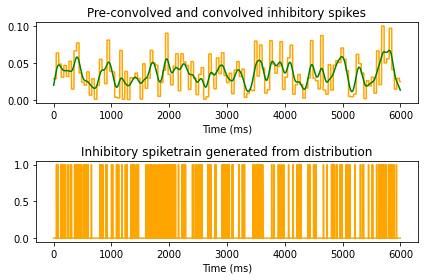

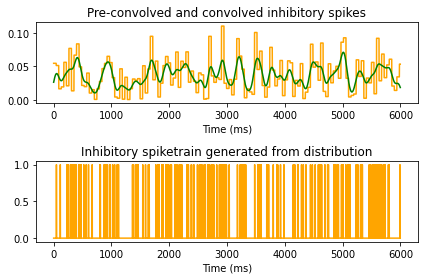

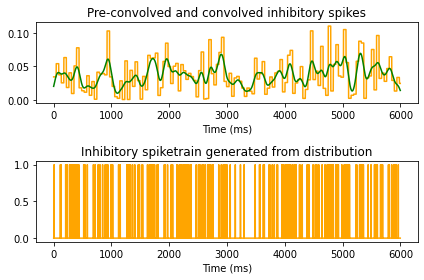

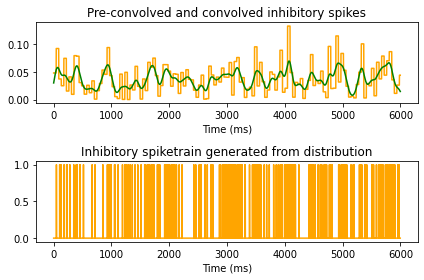

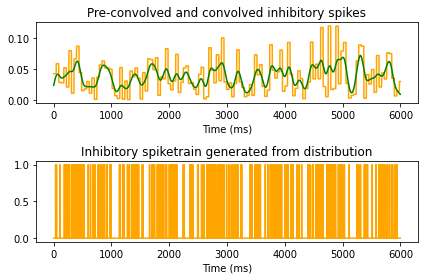

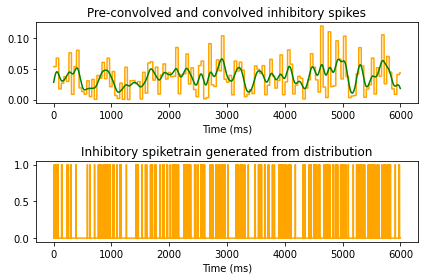

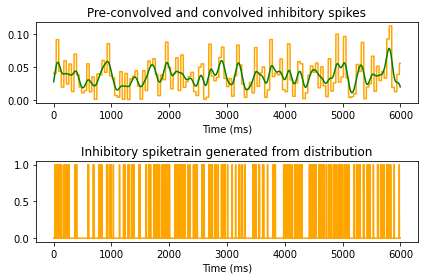

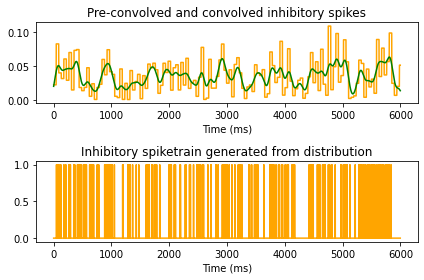

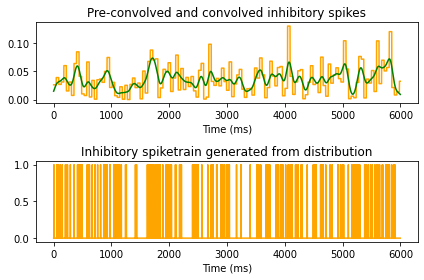

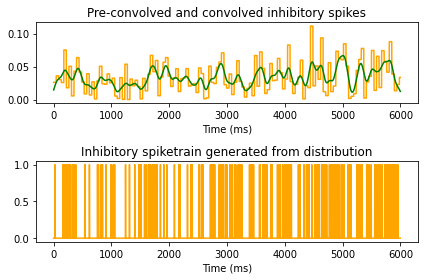

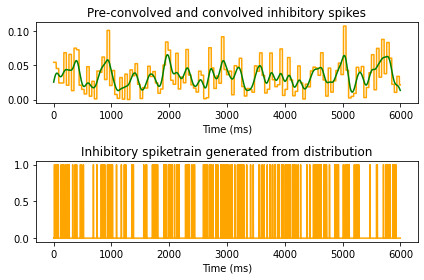

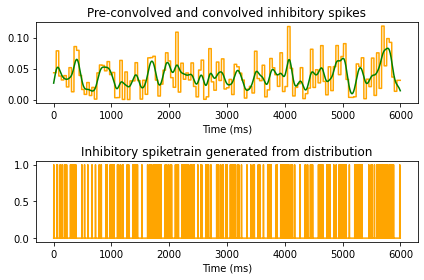

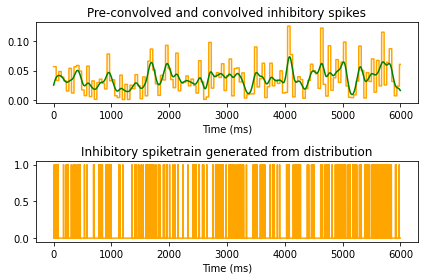

In [9]:
random_seed = 1234
np.random.seed(random_seed)

# simulation params
num_ex_synapses  = 80
num_inh_synapses = 20
num_synapses     = num_ex_synapses + num_inh_synapses

v_reset     = -75
v_threshold = -55
current_to_voltage_mult_factor = 2
membrane_time_const = 20

# create synaptic weights vector "w"
synaptic_weights = np.ones((num_synapses, 1))
exc_inds  = range(num_ex_synapses)
inh_inds = list(set(range(num_synapses)) - set(exc_inds))
synaptic_weights[exc_inds] *=  1.0
synaptic_weights[inh_inds] *= -1.0

sim_duration_ms  = 6000
sim_duration_sec = sim_duration_ms / 1000.0

inst_rate_sampling_time_interval_options_ms   = [25,30,35,40,50,60,70,80,90,100]
temporal_inst_rate_smoothing_sigma_options_ms = [40,60,80,100]

inst_rate_sampling_time_interval_jitter_range   = 20
temporal_inst_rate_smoothing_sigma_jitter_range = 20

num_exc_spikes_per_100ms_range = [0, 50]
num_exc_inh_spike_diff_per_100ms_range = [-50, -15]

generate_input_spike_trains_for_simulation(num_exc=80, num_inh=20)